# Efficiency losses for compute repricings

#### Maria Silva, November 2025

In [1]:
import os
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

## Load and process data

In [3]:
# Main directories
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")

First, let's load the empirical data from EIP-7904. This data was taken directly from the [EIP's additional files](https://github.com/ethereum/EIPs/blob/master/assets/eip-7904/final_gas_schedule_comparison.csv).

In [4]:
df = pd.read_csv(os.path.join(data_dir, "final_gas_schedule_comparison.csv"))
df = df.drop(columns=["ethereumjs_gas", "ethereumjs_gas_stderr", "evmone_gas", "evmone_gas_stderr"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   besu_gas                    167 non-null    float64
 1   besu_gas_stderr             167 non-null    float64
 2   erigon_gas                  166 non-null    float64
 3   erigon_gas_stderr           166 non-null    float64
 4   geth_gas                    166 non-null    float64
 5   geth_gas_stderr             166 non-null    float64
 6   nethermind_gas              166 non-null    float64
 7   nethermind_gas_stderr       166 non-null    float64
 8   revm_gas                    154 non-null    float64
 9   revm_gas_stderr             154 non-null    float64
 10  opcode                      167 non-null    object 
 11  constant_current_gas        167 non-null    float64
 12  alternative_gas             167 non-null    float64
 13  alternative_gas_stderr      167 non

In [5]:
client_gas_cols = [c for c in df.columns[:9] if c.endswith("_gas")]
worse_df = df.copy()
# Get slowest value across clients 
worse_df["param_ns"] = df[client_gas_cols].max(axis=1)
# Select columns
worse_df = worse_df[["opcode", "param_ns", "constant_current_gas"]]
# Exclude near-zeros from the analysis
worse_df = worse_df[~worse_df["opcode"].isin(["REVERT_ARG1", "RETURN_ARG1", "RETURNDATACOPY_ARG2"])]

Now, let's filter only the pure compute & memory operations and precompiles (for simplicity) and get the worse timings for each operation.

In [6]:
with open(os.path.join(data_dir, "compute_ops.txt"), "r") as f:
    compute_ops_list = f.read().splitlines()
compute_ops_list = [op for op in compute_ops_list if ("#" not in op) and (op != "")]
compute_ops_list = [op.split(" = ")[0] for op in compute_ops_list]

with open(os.path.join(data_dir, "mem_ops.txt"), "r") as f:
    memory_ops_list = f.read().splitlines()
memory_ops_list = [op for op in memory_ops_list if ("#" not in op) and (op != "")]
memory_ops_list = [op.split(" = ")[0] for op in memory_ops_list]

precomp_list = [
    "ECRECOVER",
    "SHA2-256",
    "RIPEMD-160",
    "IDENTITY",
    "MODEXP",
    "ECADD",
    "ECMUL",
    "ECPAIRING79000",
    "ECPAIRING113000",
    "ECPAIRING181000",
    "ECPAIRING317000",
    "BLAKE2F",
]

In [7]:
client_gas_cols = [c for c in df.columns[:9] if c.endswith("_gas")]
worse_df = df[df["opcode"].isin(compute_ops_list+precomp_list+memory_ops_list)]
# Get slowest value across clients 
worse_df["param_ns"] = df[client_gas_cols].max(axis=1)
# Select columns
worse_df = worse_df[["opcode", "param_ns", "constant_current_gas"]]
# Exclude zeros from the analysis
worse_df = worse_df[~worse_df["opcode"].isin(["REVERT", "RETURN"])]

worse_df

,opcode,param_ns,constant_current_gas
0,ADD,7.171282e+00,3.0
1,MUL,8.143532e+00,5.0
2,SUB,6.806273e+00,3.0
3,DIV,5.826503e+00,5.0
4,SDIV,9.435828e+00,5.0
...,...,...,...
145,ECPAIRING181000,1.074028e+06,181100.0
146,ECPAIRING317000,1.967311e+06,317100.0
147,BLAKE2F,2.581135e+02,112.0
148,TLOAD,2.860756e+01,100.0


## Compute efficiency losses for 300M gas limit @4s execution time

In [8]:
limit = 300*1e6
ex_time = 4*1e9
params_df = worse_df.copy()
# current
params_df["op_per_time"] = np.floor(ex_time/params_df["param_ns"]).astype(int)
params_df["op_per_limit_current"] = np.floor(limit/params_df["constant_current_gas"]).astype(int)
params_df["eff_loss_current"] = (params_df["op_per_time"]/params_df["op_per_limit_current"])-1
# new gas rounded
params_df["new_gas_rounded"] = np.ceil((limit*params_df["param_ns"])/ex_time).astype(int)
params_df["op_per_limit_rounded"] = np.floor(limit/params_df["new_gas_rounded"]).astype(int)
params_df["eff_loss_rounded"] = (params_df["op_per_time"]/params_df["op_per_limit_rounded"])-1
# new gas fractional
params_df["new_gas_frac"] = np.ceil(100*(limit*params_df["param_ns"])/ex_time)/100
params_df["op_per_limit_frac"] = np.floor(limit/params_df["new_gas_frac"]).astype(int)
params_df["eff_loss_frac"] = (params_df["op_per_time"]/params_df["op_per_limit_frac"])-1
# new gas minimal
params_df["new_gas_minimal"] = np.ceil((limit*params_df["param_ns"])/ex_time).astype(int)
params_df["new_gas_minimal"] = np.where(
    params_df["new_gas_minimal"]>params_df["constant_current_gas"], 
    params_df["new_gas_minimal"], 
    params_df["constant_current_gas"]
    )
params_df["op_per_limit_minimal"] = np.floor(limit/params_df["new_gas_minimal"]).astype(int)
params_df["eff_loss_minimal"] = (params_df["op_per_time"]/params_df["op_per_limit_minimal"])-1

params_df

,opcode,param_ns,constant_current_gas,op_per_time,op_per_limit_current,eff_loss_current,new_gas_rounded,op_per_limit_rounded,eff_loss_rounded,new_gas_frac,op_per_limit_frac,eff_loss_frac,new_gas_minimal,op_per_limit_minimal,eff_loss_minimal
0,ADD,7.171282e+00,3.0,557780325,100000000,4.577803,1,300000000,0.859268,0.54,555555555,0.004005,3.0,100000000,4.577803
1,MUL,8.143532e+00,5.0,491187377,60000000,7.186456,1,300000000,0.637291,0.62,483870967,0.015121,5.0,60000000,7.186456
2,SUB,6.806273e+00,3.0,587693151,100000000,4.876932,1,300000000,0.958977,0.52,576923076,0.018668,3.0,100000000,4.876932
3,DIV,5.826503e+00,5.0,686518180,60000000,10.441970,1,300000000,1.288394,0.44,681818181,0.006893,5.0,60000000,10.441970
4,SDIV,9.435828e+00,5.0,423916164,60000000,6.065269,1,300000000,0.413054,0.71,422535211,0.003268,5.0,60000000,6.065269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ECPAIRING181000,1.074028e+06,181100.0,3724,1656,1.248792,80553,3724,0.000000,80552.12,3724,0.000000,181100.0,1656,1.248792
146,ECPAIRING317000,1.967311e+06,317100.0,2033,946,1.149049,147549,2033,0.000000,147548.35,2033,0.000000,317100.0,946,1.149049
147,BLAKE2F,2.581135e+02,112.0,15497057,2678571,4.785569,20,15000000,0.033137,19.36,15495867,0.000077,112.0,2678571,4.785569
148,TLOAD,2.860756e+01,100.0,139823159,3000000,45.607720,3,100000000,0.398232,2.15,139534883,0.002066,100.0,3000000,45.607720


In [9]:
params_df[params_df["new_gas_minimal"]>params_df["constant_current_gas"]]

,opcode,param_ns,constant_current_gas,op_per_time,op_per_limit_current,eff_loss_current,new_gas_rounded,op_per_limit_rounded,eff_loss_rounded,new_gas_frac,op_per_limit_frac,eff_loss_frac,new_gas_minimal,op_per_limit_minimal,eff_loss_minimal
141,ECADD,3642.884099,250.0,1098031,1200000,-0.084974,274,1094890,0.002869,273.22,1098016,0.000014,274.0,1094890,0.002869


In [10]:
print("Number of repriced opcodes:")
print("Minimal repricing:", sum(params_df["new_gas_minimal"]!=params_df["constant_current_gas"]))
print("Rounded repricing:", sum(params_df["new_gas_rounded"]!=params_df["constant_current_gas"]))
print("Fractional repricing:", sum(params_df["new_gas_frac"]!=params_df["constant_current_gas"]))

Number of repriced opcodes:
Minimal repricing: 1
Rounded repricing: 131
Fractional repricing: 133


## Efficiency losses per opcode

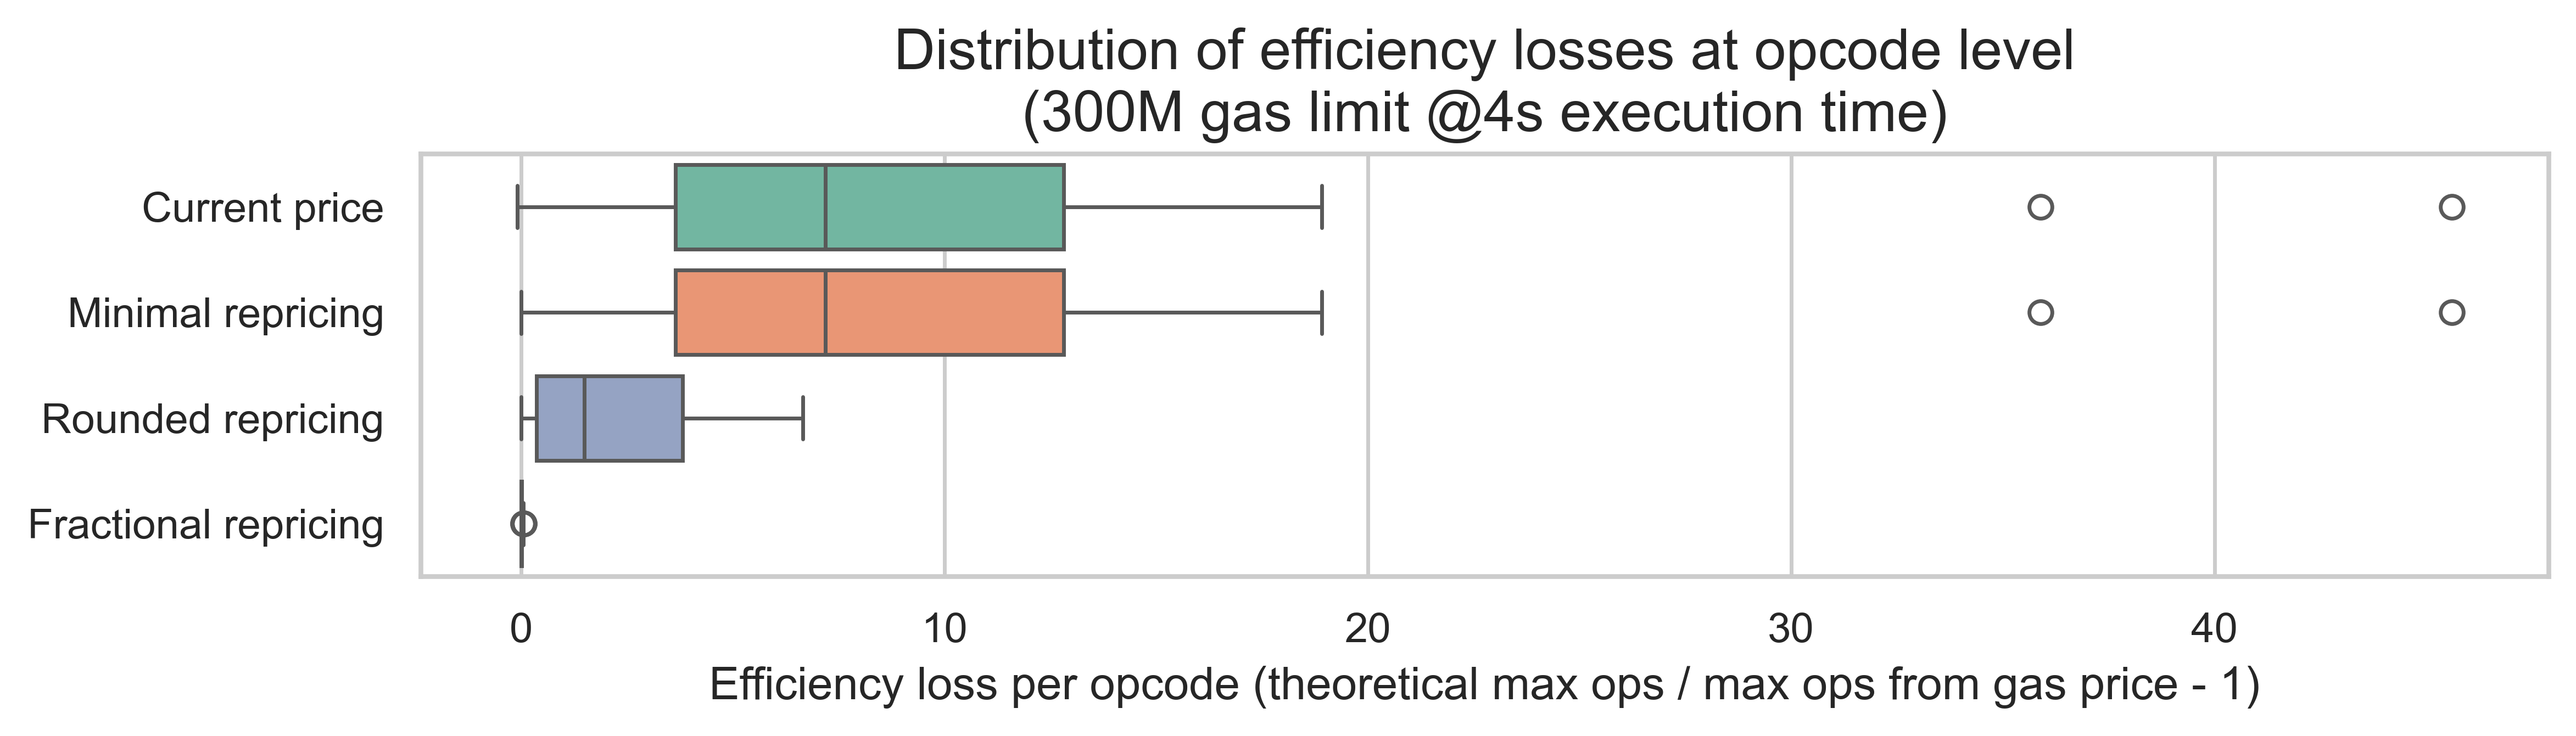

In [11]:
eff_loss_df = params_df[
    [
        "opcode",
        "eff_loss_current",
        "eff_loss_minimal",
        "eff_loss_rounded",
        "eff_loss_frac",
    ]
]
eff_cols = ["Current price","Minimal repricing", "Rounded repricing", "Fractional repricing"]
eff_loss_df.columns = ["opcode"] + eff_cols
eff_loss_df = eff_loss_df.melt(
    id_vars=["opcode"],
    value_vars=eff_cols,
    var_name="repricing_strategy",
    value_name="efficiency_loss",
)

plt.figure(figsize=(10, 2))
sns.boxplot(
    data=eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.title("Distribution of efficiency losses at opcode level\n(300M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per opcode (theoretical max ops / max ops from gas price - 1)")
plt.show()

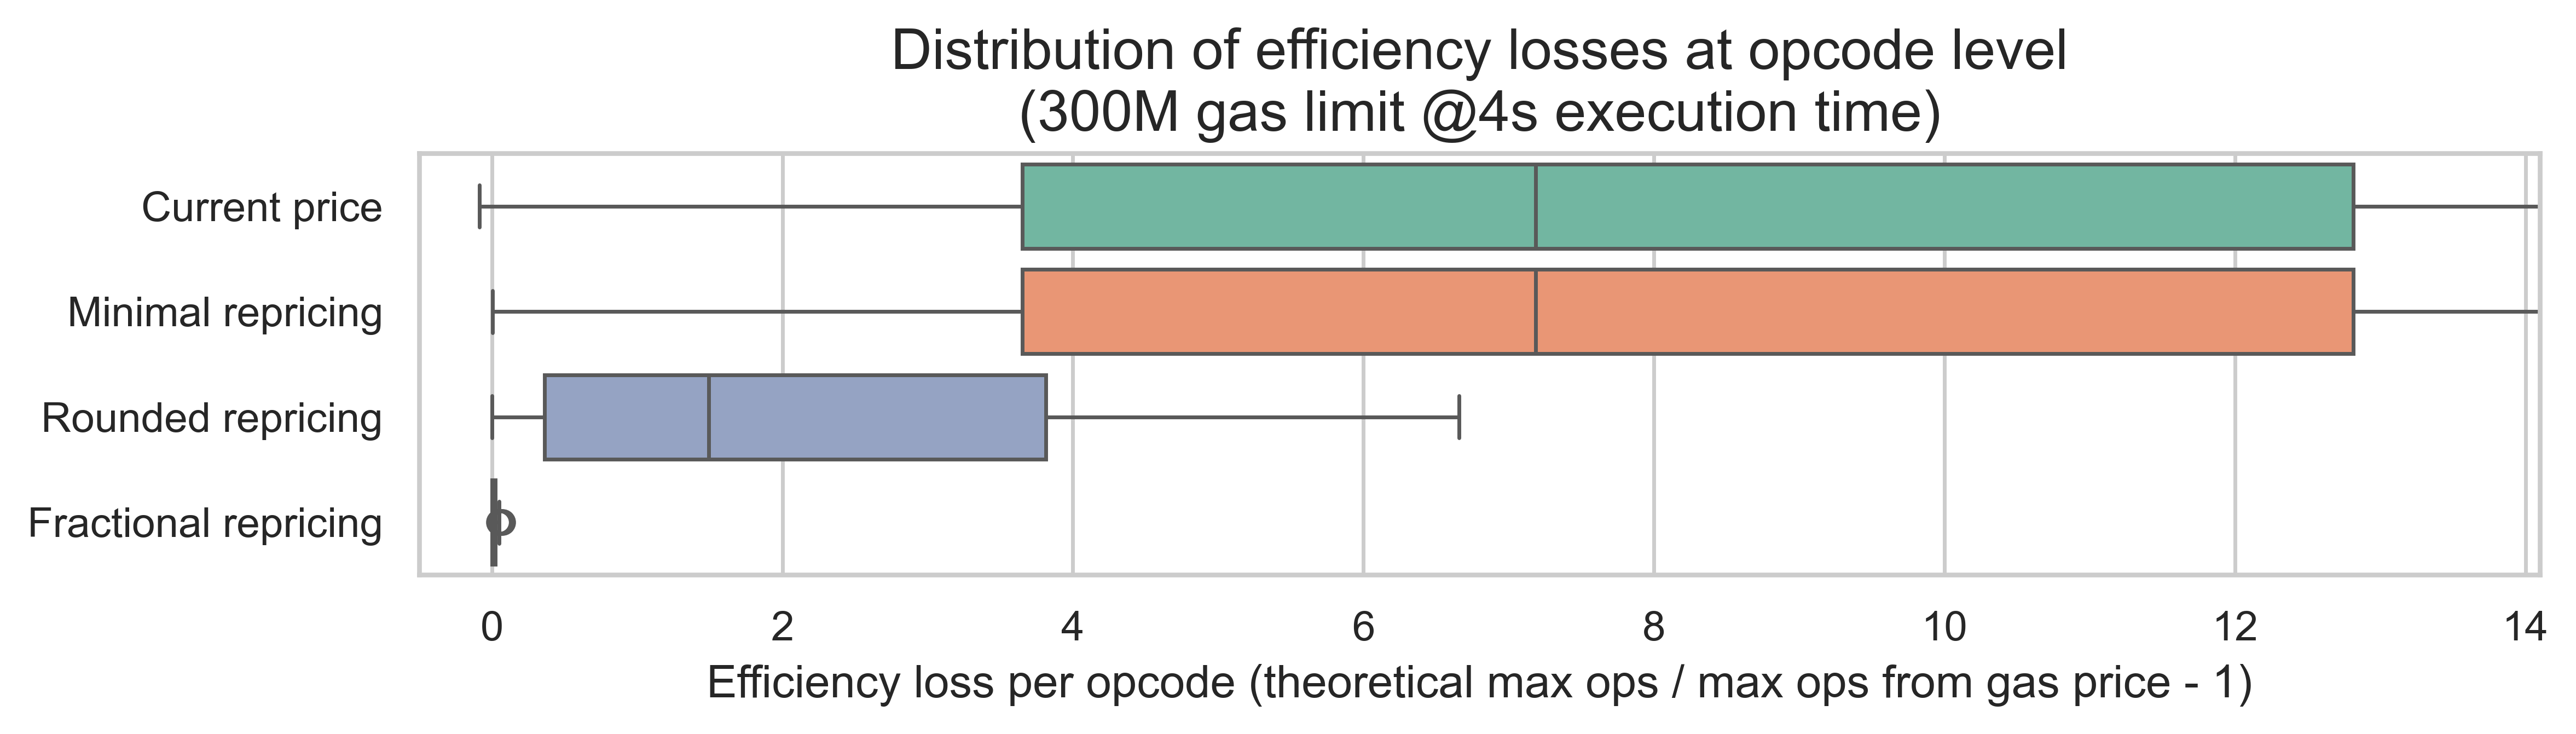

In [12]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.xlim(-0.5,14.1)
plt.title("Distribution of efficiency losses at opcode level\n(300M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per opcode (theoretical max ops / max ops from gas price - 1)")
plt.show()

## Efficiency losses per transaction

In [13]:
block_start = 22000000
block_end = 22001000
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v3", "*", "file.parquet")
# Load parquet files with duckdb
query = f"""
SELECT 
    block_height,
    tx_hash,
    op AS opcode,
    op_gas_cost,
    op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN {block_start} AND {block_end};
"""
agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Print info
agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934668 entries, 0 to 12934667
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   opcode             object 
 3   op_gas_cost        float64
 4   op_gas_pair_count  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 493.4+ MB


In [14]:
# Join gas costs with transaction traces
cols = ["param_ns", "new_gas_minimal", "new_gas_rounded", "new_gas_frac"]
tx_params_df = agg_trace_df.merge(params_df[["opcode"] + cols], on="opcode", how="left")
tx_params_df["param_ns"] = tx_params_df["param_ns"].fillna(
    tx_params_df["op_gas_cost"] * ex_time / limit
)
tx_params_df["new_gas_minimal"] = tx_params_df["new_gas_minimal"].fillna(
    tx_params_df["op_gas_cost"]
)
tx_params_df["new_gas_rounded"] = tx_params_df["new_gas_rounded"].fillna(
    tx_params_df["op_gas_cost"]
)
tx_params_df["new_gas_frac"] = tx_params_df["new_gas_frac"].fillna(
    tx_params_df["op_gas_cost"]
)
# Compute total cost per transaction
tx_params_df[cols + ["op_gas_cost"]] = tx_params_df[cols + ["op_gas_cost"]].mul(
    tx_params_df["op_gas_pair_count"], axis=0
)
tx_params_df = (
    tx_params_df.groupby(["tx_hash"])[cols + ["op_gas_cost"]].sum().reset_index()
)
tx_params_df["new_gas_frac"] = np.ceil(tx_params_df["new_gas_frac"])
# cleanup column names
tx_params_df.columns = [
    "tx_hash",
    "total_ex_time_ns",
    "total_gas_minimal",
    "total_gas_rounded",
    "total_gas_frac",
    "total_gas_current",
]
# Compute efficiency metrics
tx_params_df["tx_per_time"] = np.floor(ex_time / tx_params_df["total_ex_time_ns"])
tx_params_df["tx_per_limit_current"] = np.floor(limit/tx_params_df["total_gas_current"])
tx_params_df["tx_per_limit_minimal"] = np.floor(limit/tx_params_df["total_gas_minimal"])
tx_params_df["tx_per_limit_rounded"] = np.floor(limit/tx_params_df["total_gas_rounded"])
tx_params_df["tx_per_limit_frac"] = np.floor(limit/tx_params_df["total_gas_frac"])
tx_params_df["eff_loss_current"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_current"])-1
tx_params_df["eff_loss_minimal"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_minimal"])-1
tx_params_df["eff_loss_rounded"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_rounded"])-1
tx_params_df["eff_loss_frac"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_frac"])-1

tx_params_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84976 entries, 0 to 84975
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tx_hash               84976 non-null  object 
 1   total_ex_time_ns      84976 non-null  float64
 2   total_gas_minimal     84976 non-null  float64
 3   total_gas_rounded     84976 non-null  float64
 4   total_gas_frac        84976 non-null  float64
 5   total_gas_current     84976 non-null  float64
 6   tx_per_time           84976 non-null  float64
 7   tx_per_limit_current  84976 non-null  float64
 8   tx_per_limit_minimal  84976 non-null  float64
 9   tx_per_limit_rounded  84976 non-null  float64
 10  tx_per_limit_frac     84976 non-null  float64
 11  eff_loss_current      84976 non-null  float64
 12  eff_loss_minimal      84976 non-null  float64
 13  eff_loss_rounded      84976 non-null  float64
 14  eff_loss_frac         84976 non-null  float64
dtypes: float64(14), obj

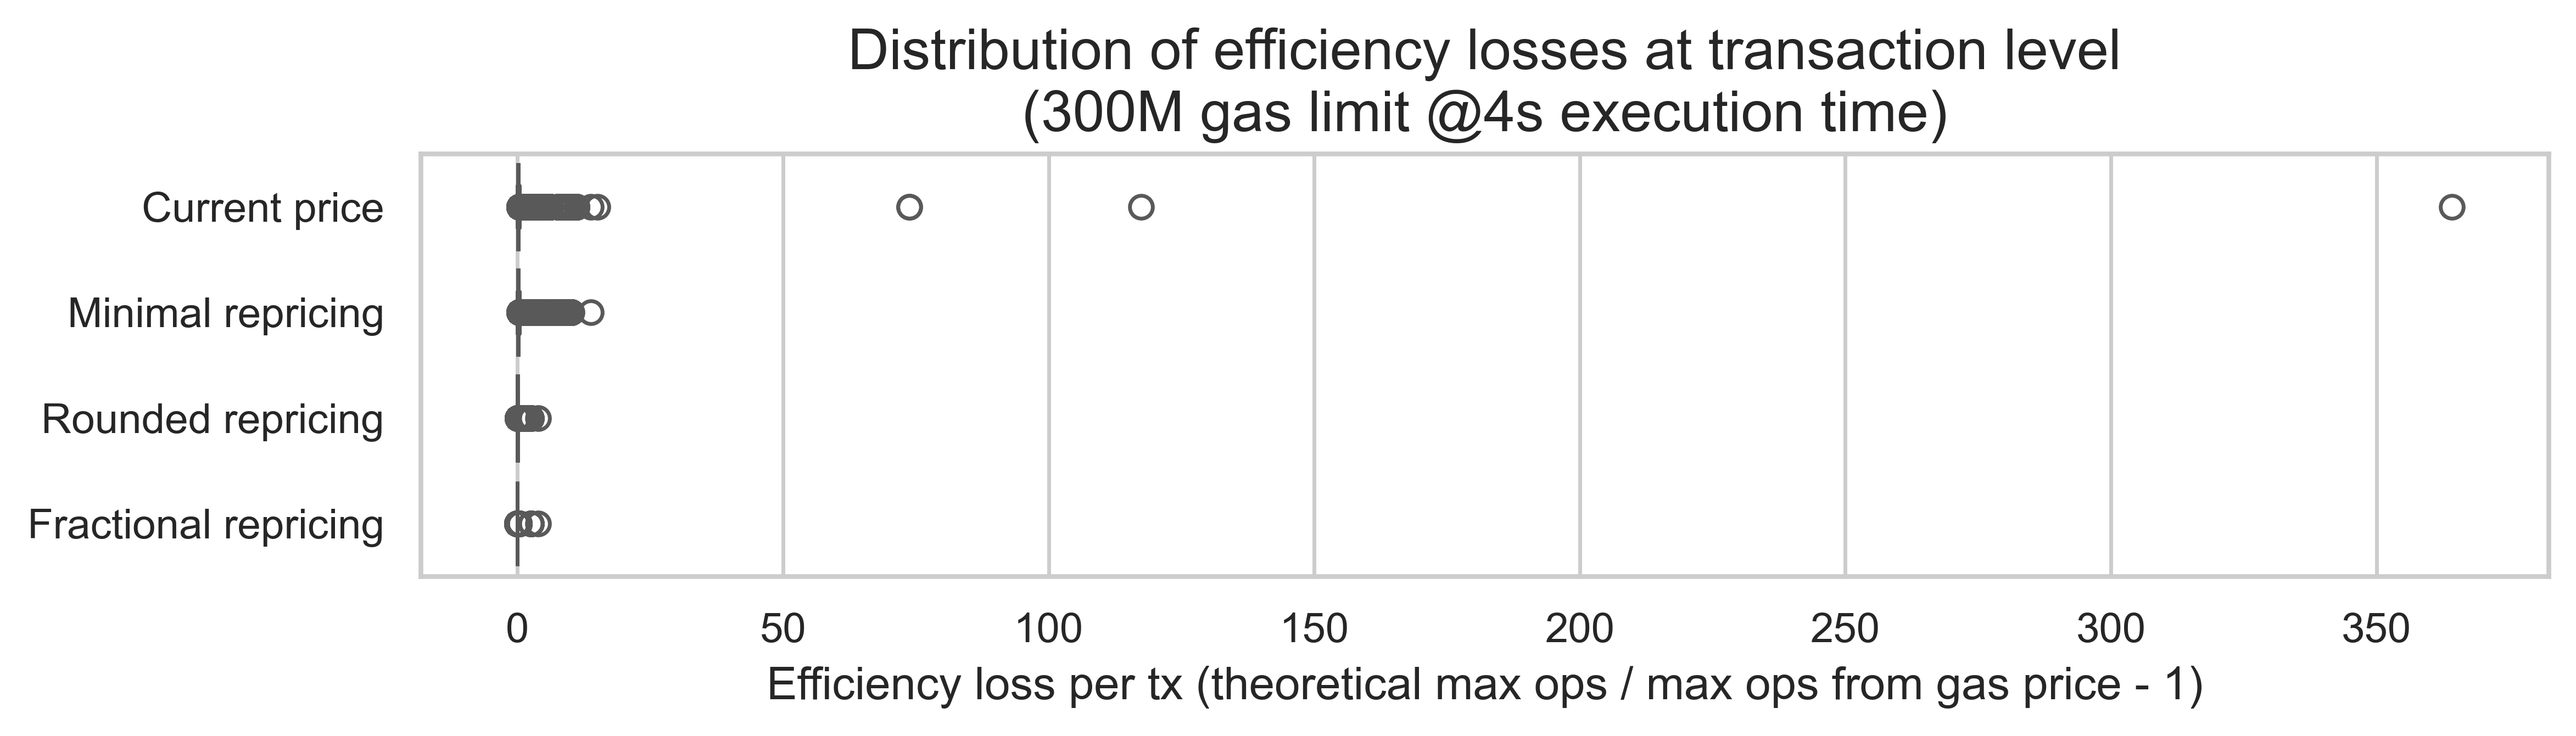

In [15]:
tx_eff_loss_df = tx_params_df[
    [
        "tx_hash",
        "eff_loss_current",
        "eff_loss_minimal",
        "eff_loss_rounded",
        "eff_loss_frac",
    ]
]
eff_cols = ["Current price", "Minimal repricing", "Rounded repricing", "Fractional repricing"]
tx_eff_loss_df.columns = ["tx_hash"] + eff_cols
tx_eff_loss_df = tx_eff_loss_df.melt(
    id_vars=["tx_hash"],
    value_vars=eff_cols,
    var_name="repricing_strategy",
    value_name="efficiency_loss",
)

plt.figure(figsize=(10, 2))
sns.boxplot(
    data=tx_eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.title("Distribution of efficiency losses at transaction level\n(300M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per tx (theoretical max ops / max ops from gas price - 1)")
plt.show()

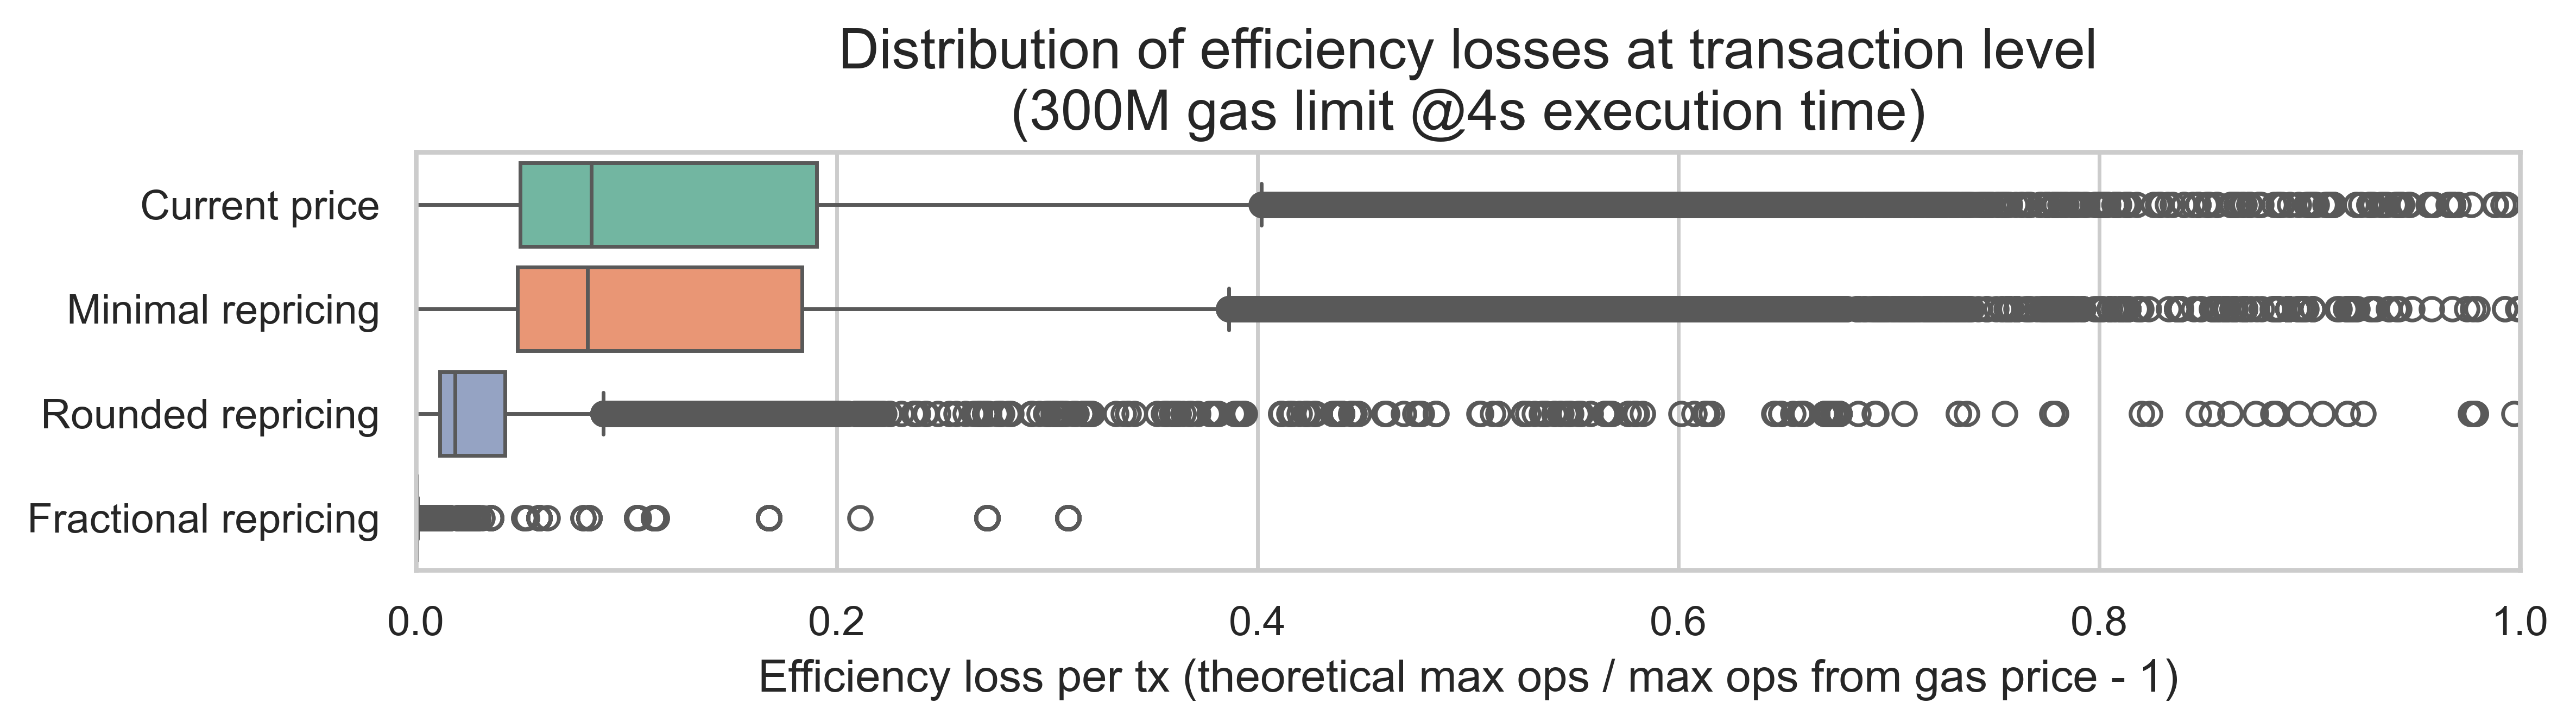

In [16]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=tx_eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.xlim(0,1)
plt.title("Distribution of efficiency losses at transaction level\n(300M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per tx (theoretical max ops / max ops from gas price - 1)")
plt.show()

In [22]:
tx_eff_loss_df[tx_eff_loss_df["efficiency_loss"] > 1].groupby("repricing_strategy").size()

repricing_strategy
Current price           943
Fractional repricing      6
Minimal repricing       836
Rounded repricing       485
dtype: int64

In [23]:
tx_eff_loss_df[tx_eff_loss_df["efficiency_loss"] > 1].groupby(
    "repricing_strategy"
).size() / tx_eff_loss_df.groupby("repricing_strategy").size().iloc[0]

repricing_strategy
Current price           0.011097
Fractional repricing    0.000071
Minimal repricing       0.009838
Rounded repricing       0.005707
dtype: float64